# Image classifier using CIFAR-10 dataset

In [0]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.12.0
2.2.4


Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 98s 1us/step


In [0]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [0]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

In [0]:
x_train2 = (x_train/255) - 0.5
x_test2 = (x_test/255) - 0.5

y_train2 = keras.utils.to_categorical(y_train,NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test,NUM_CLASSES)

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten , Dense, Activation,Dropout
from keras.layers.advanced_activations import LeakyReLU

In [0]:
def make_model():
  model = Sequential()
  
  model.add(Conv2D(16,(3,3),padding = 'same', activation = 'relu',input_shape = (32,32,3)))
  model.add(Conv2D(32,(3,3),padding = 'same',activation = 'relu', input_shape = (32,32,3)))
  model.add(MaxPooling2D(pool_size= (2,2), strides = None, padding = 'valid',data_format = None))
  model.add(Dropout(0.25))
  model.add(Conv2D(32,(3,3),padding = 'same', activation = 'relu', input_shape = (32,32,3)))
  model.add(Conv2D(64,(3,3),padding = 'same', activation = 'relu', input_shape = (32,32,3)))
  model.add(MaxPooling2D(pool_size = (2,2),strides = None, padding = 'valid',data_format = None))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256,input_shape = (256,)))
  model.add(Dense(NUM_CLASSES))
  model.add(LeakyReLU(0.1))
  model.add(Activation('softmax'))
  
  return model

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s
tf.reset_default_graph()
s= reset_tf_session()
modelTf = make_model()
modelTf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [0]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
modelTf = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
modelTf.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(modelTf.optimizer.lr))

In [0]:
# we will save model checkpoints to continue training in case of kernel death
modelTf.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    callbacks = [keras.callbacks.LearningRateScheduler(lr_scheduler),
                 LrHistory(),
        tbCallBack],
    initial_epoch= 0
)

Learning rate: 0.005
Learning rate: 0.0045
Learning rate: 0.00405
Learning rate: 0.003645
Learning rate: 0.0032805
Learning rate: 0.00295245
Learning rate: 0.002657205
Learning rate: 0.0023914846
Learning rate: 0.002152336
Learning rate: 0.0019371024


In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-01-23 15:12:23--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.200.123.104, 52.207.111.186, 52.203.53.176, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.200.123.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  3.46MB/s    in 1.5s    

2019-01-23 15:12:25 (3.46 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:

LOG_DIR = './log/cn3'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://c0cc2918.ngrok.io


In [0]:
import time
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log/cn3', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=BATCH_SIZE,
                         write_images=True)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


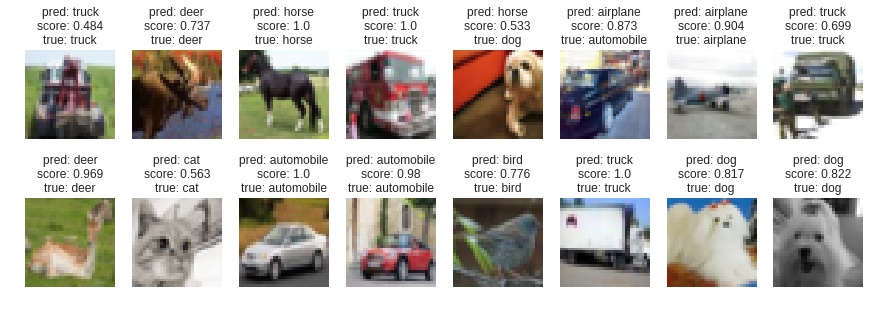

In [0]:
y_pred_test = modelTf.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()